# 7 Working with Keras: A deep dive

**Important**: this notebook contains examples in TensorFlow, PyTorch and JAX, that can't all be run at the same time. Only examples with a single backend can be run at any given time! (To try the other backends, you have to restart the kernel, change the import, and run the appropriate cells.

In [1]:
import os
import time
import pathlib
from tqdm import tqdm
from matplotlib import pyplot as plt

import tensorflow as tf
import torch
import jax

from IPython.core.magic import register_cell_magic

os.environ["KERAS_BACKEND"] = "tensorflow" # jax / torch

import keras

@register_cell_magic
def backend(line, cell):
    current, required = os.environ.get("KERAS_BACKEND", ""), line.split()[-1]
    if current == required:
        get_ipython().run_cell(cell)
    else:
        print(
            f"This cell requires the {required} backend. To run it, change KERAS_BACKEND to "
            f"\"{required}\" at the top of the notebook, restart the runtime, and rerun the notebook."
        )

## Using built-in training and evaluation loops

In [3]:
def get_mnist_model():
    inputs = keras.Input(shape=(28 * 28,))
    features = keras.layers.Dense(512, activation="relu")(inputs)
    features = keras.layers.Dropout(0.5)(features)
    outputs = keras.layers.Dense(10, activation="softmax")(features)
    model = keras.Model(inputs, outputs)
    return model

(images, labels), (test_images, test_labels) = keras.datasets.mnist.load_data()
images = images.reshape((60000, 28 * 28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28)).astype("float32") / 255
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

model = get_mnist_model()
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_images,
    train_labels,
    epochs=3,
    validation_data=(val_images, val_labels),
)
test_metrics = model.evaluate(test_images, test_labels)
predictions = model.predict(test_images)

Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.9141 - loss: 0.2898 - val_accuracy: 0.9606 - val_loss: 0.1379
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.9557 - loss: 0.1484 - val_accuracy: 0.9698 - val_loss: 0.1031
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9640 - loss: 0.1155 - val_accuracy: 0.9736 - val_loss: 0.0876
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9736 - loss: 0.0795
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


### Writing your own metrics

In [10]:
class RootMeanSquaredError(keras.metrics.Metric):
    def __init__(self, name="rmse", **kwargs):
        super().__init__(name=name, **kwargs)
        self.mse_sum = self.add_weight(name="mse_sum", initializer="zeros")
        self.total_samples = self.add_weight(
            name="total_samples", initializer="zeros"
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = keras.ops.one_hot(y_true, num_classes=keras.ops.shape(y_pred)[1])
        mse = keras.ops.sum(keras.ops.square(y_true - y_pred))
        self.mse_sum.assign_add(mse)
        num_samples = keras.ops.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)

    def result(self):
        return keras.ops.sqrt(self.mse_sum / self.total_samples)

    def reset_state(self):
        self.mse_sum.assign(0.)
        self.total_samples.assign(0.)

In [11]:
model = get_mnist_model()
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy", RootMeanSquaredError()],
)
model.fit(
    train_images,
    train_labels,
    epochs=3,
    validation_data=(val_images, val_labels),
)
test_metrics = model.evaluate(test_images, test_labels)

Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9124 - loss: 0.2907 - rmse: 0.3622 - val_accuracy: 0.9580 - val_loss: 0.1422 - val_rmse: 0.2508
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9537 - loss: 0.1499 - rmse: 0.2654 - val_accuracy: 0.9677 - val_loss: 0.1054 - val_rmse: 0.2205
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9640 - loss: 0.1164 - rmse: 0.2346 - val_accuracy: 0.9711 - val_loss: 0.0915 - val_rmse: 0.2062
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - accuracy: 0.9730 - loss: 0.0861 - rmse: 0.2012


### Using callbacks

In [12]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []

    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))

    def on_epoch_end(self, epoch, logs):
        plt.clf()
        plt.plot(
            range(len(self.per_batch_losses)),
            self.per_batch_losses,
            label="Training loss for each batch",
        )
        plt.xlabel(f"Batch (epoch {epoch})")
        plt.ylabel("Loss")
        plt.legend()
        # plt.savefig(f"plot_at_epoch_{epoch}", dpi=300)
        self.per_batch_losses = []

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9130 - loss: 0.2894 - val_accuracy: 0.9590 - val_loss: 0.1391
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9557 - loss: 0.1469 - val_accuracy: 0.9701 - val_loss: 0.0995
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9643 - loss: 0.1150 - val_accuracy: 0.9724 - val_loss: 0.0904
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9696 - loss: 0.0965 - val_accuracy: 0.9775 - val_loss: 0.0760
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9727 - loss: 0.0856 - val_accuracy: 0.9787 - val_loss: 0.0785
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9768 - loss: 0.0744 - val_accuracy: 0.9766 - val_loss: 0.0810
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9784 - loss: 0.0664 - val_accuracy: 0.9777 - val_loss: 0.0793
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9787 - loss: 0.0633 - 

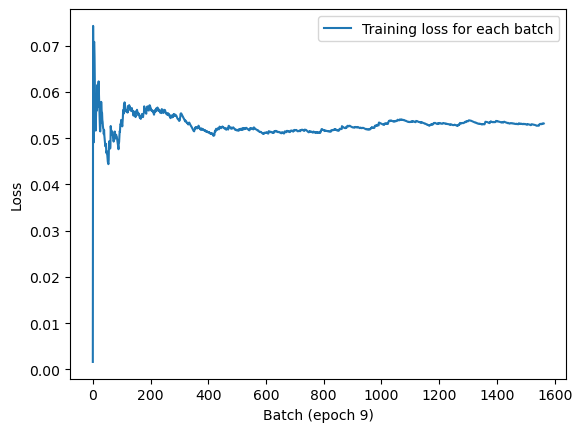

In [13]:
model = get_mnist_model()
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_images,
    train_labels,
    epochs=10,
    callbacks=[LossHistory()],
    validation_data=(val_images, val_labels),
)

### Monitoring and visualization with TensorBoard

In [ ]:
model = get_mnist_model()
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

tensorboard = keras.callbacks.TensorBoard(
    log_dir="/full_path_to_your_log_dir",
)
model.fit(
    train_images,
    train_labels,
    epochs=10,
    validation_data=(val_images, val_labels),
    callbacks=[tensorboard],
)

## Writing your own training and evaluation loops

### Training vs. inference

See this section [in the book](https://deeplearningwithpython.io/chapters/chapter07_deep-dive-keras/#training-vs-inference).

### Writing custom training step functions

#### A TensorFlow training step function

In [14]:
%%backend tensorflow

model = get_mnist_model()
loss_fn = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam()

def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(targets, predictions)
    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply(gradients, model.trainable_weights)
    return loss

In [16]:
%%backend tensorflow
batch_size = 32
inputs = train_images[:batch_size]
targets = train_labels[:batch_size]
loss = train_step(inputs, targets)
print(loss)

tf.Tensor(2.2530875, shape=(), dtype=float32)


#### A PyTorch training step function

In [4]:
%%backend torch

model = get_mnist_model()
loss_fn = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam()

def train_step(inputs, targets):
    predictions = model(inputs, training=True)
    loss = loss_fn(targets, predictions)
    loss.backward()
    gradients = [weight.value.grad for weight in model.trainable_weights]
    with torch.no_grad():
        optimizer.apply(gradients, model.trainable_weights)
    model.zero_grad()
    return loss

In [6]:
%%backend torch
batch_size = 32
inputs = train_images[:batch_size]
targets = train_labels[:batch_size]
loss = train_step(inputs, targets)
print(loss)

tensor(2.0363, device='mps:0', grad_fn=<WhereBackward0>)


#### A JAX training step function

In [4]:
%%backend jax

model = get_mnist_model()
loss_fn = keras.losses.SparseCategoricalCrossentropy()

def compute_loss_and_updates(
    trainable_variables, non_trainable_variables, inputs, targets
):
    outputs, non_trainable_variables = model.stateless_call(
        trainable_variables, non_trainable_variables, inputs, training=True
    )
    loss = loss_fn(targets, outputs)
    return loss, non_trainable_variables

In [5]:
%%backend jax

grad_fn = jax.value_and_grad(compute_loss_and_updates, has_aux=True)

In [6]:
%%backend jax

optimizer = keras.optimizers.Adam()
optimizer.build(model.trainable_variables)

def train_step(state, inputs, targets):
    (trainable_variables, non_trainable_variables, optimizer_variables) = state
    (loss, non_trainable_variables), grads = grad_fn(
        trainable_variables, non_trainable_variables, inputs, targets
    )
    trainable_variables, optimizer_variables = optimizer.stateless_apply(
        optimizer_variables, grads, trainable_variables
    )
    return loss, (
        trainable_variables,
        non_trainable_variables,
        optimizer_variables,
    )

In [11]:
%%backend jax

batch_size = 32
inputs = train_images[:batch_size]
targets = train_labels[:batch_size]

trainable_variables = [v.value for v in model.trainable_variables]
non_trainable_variables = [v.value for v in model.non_trainable_variables]
optimizer_variables = [v.value for v in optimizer.variables]

state = (trainable_variables, non_trainable_variables, optimizer_variables)
loss, state = train_step(state, inputs, targets)
print(loss)

2.4628203


### Low-level usage of metrics

In [17]:
metric = keras.metrics.SparseCategoricalAccuracy()
targets = keras.ops.array([0, 1, 2])
predictions = keras.ops.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
metric.update_state(targets, predictions)
current_result = metric.result()
print(f"result: {current_result:.2f}")

result: 1.00


In [18]:
values = keras.ops.array([0, 1, 2, 3, 4])
mean_tracker = keras.metrics.Mean()
for value in values:
    mean_tracker.update_state(value)
print(f"Mean of values: {mean_tracker.result():.2f}")

Mean of values: 2.00


In [19]:
metric = keras.metrics.SparseCategoricalAccuracy()
targets = keras.ops.array([0, 1, 2])
predictions = keras.ops.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

metric_variables = metric.variables
metric_variables = metric.stateless_update_state(
    metric_variables, targets, predictions
)
current_result = metric.stateless_result(metric_variables)
print(f"result: {current_result:.2f}")

metric_variables = metric.stateless_reset_state()

result: 1.00


### Using `fit()` with a custom training loop

#### Customizing `fit()` with TensorFlow

In [20]:
%%backend tensorflow

loss_fn = keras.losses.SparseCategoricalCrossentropy()
loss_tracker = keras.metrics.Mean(name="loss")

class CustomModel(keras.Model):
    def train_step(self, data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True)
            loss = loss_fn(targets, predictions)
        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply(gradients, self.trainable_weights)

        loss_tracker.update_state(loss)
        return {"loss": loss_tracker.result()}

    @property
    def metrics(self):
        return [loss_tracker]

In [21]:
%%backend tensorflow
def get_custom_model():
    inputs = keras.Input(shape=(28 * 28,))
    features = keras.layers.Dense(512, activation="relu")(inputs)
    features = keras.layers.Dropout(0.5)(features)
    outputs = keras.layers.Dense(10, activation="softmax")(features)
    model = CustomModel(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam())
    return model

In [22]:
%%backend tensorflow
model = get_custom_model()
model.fit(train_images, train_labels, epochs=3)

Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.2891
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1463
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1000us/step - loss: 0.1134


#### Customizing `fit()` with PyTorch

In [7]:
%%backend torch

loss_fn = keras.losses.SparseCategoricalCrossentropy()
loss_tracker = keras.metrics.Mean(name="loss")

class CustomModel(keras.Model):
    def train_step(self, data):
        inputs, targets = data
        predictions = self(inputs, training=True)
        loss = loss_fn(targets, predictions)

        loss.backward()
        trainable_weights = [v for v in self.trainable_weights]
        gradients = [v.value.grad for v in trainable_weights]

        with torch.no_grad():
            self.optimizer.apply(gradients, trainable_weights)

        loss_tracker.update_state(loss)
        return {"loss": loss_tracker.result()}

    @property
    def metrics(self):
        return [loss_tracker]

In [8]:
%%backend torch

def get_custom_model():
    inputs = keras.Input(shape=(28 * 28,))
    features = keras.layers.Dense(512, activation="relu")(inputs)
    features = keras.layers.Dropout(0.5)(features)
    outputs = keras.layers.Dense(10, activation="softmax")(features)
    model = CustomModel(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam())
    return model

In [9]:
%%backend torch

model = get_custom_model()
model.fit(train_images, train_labels, epochs=3)

Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 1.4464
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 1.4658
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 1.5782


#### Customizing `fit()` with JAX

In [12]:
%%backend jax

loss_fn = keras.losses.SparseCategoricalCrossentropy()

class CustomModel(keras.Model):
    def compute_loss_and_updates(
        self,
        trainable_variables,
        non_trainable_variables,
        inputs,
        targets,
        training=False,
    ):
        predictions, non_trainable_variables = self.stateless_call(
            trainable_variables,
            non_trainable_variables,
            inputs,
            training=training,
        )
        loss = loss_fn(targets, predictions)
        return loss, non_trainable_variables

    def train_step(self, state, data):
        (
            trainable_variables,
            non_trainable_variables,
            optimizer_variables,
            metrics_variables,
        ) = state
        inputs, targets = data

        grad_fn = jax.value_and_grad(
            self.compute_loss_and_updates, has_aux=True
        )

        (loss, non_trainable_variables), grads = grad_fn(
            trainable_variables,
            non_trainable_variables,
            inputs,
            targets,
            training=True,
        )

        (
            trainable_variables,
            optimizer_variables,
        ) = self.optimizer.stateless_apply(
            optimizer_variables, grads, trainable_variables
        )

        logs = {"loss": loss}
        state = (
            trainable_variables,
            non_trainable_variables,
            optimizer_variables,
            metrics_variables,
        )
        return logs, state

In [13]:
%%backend jax
def get_custom_model():
    inputs = keras.Input(shape=(28 * 28,))
    features = keras.layers.Dense(512, activation="relu")(inputs)
    features = keras.layers.Dropout(0.5)(features)
    outputs = keras.layers.Dense(10, activation="softmax")(features)
    model = CustomModel(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam())
    return model

In [14]:
%%backend jax
model = get_custom_model()
model.fit(train_images, train_labels, epochs=3)

Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0000e+00
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 906us/step - loss: 0.0000e+00
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 919us/step - loss: 0.0000e+00


### Handling metrics in a custom `train_step()`

#### `train_step()` metrics handling with TensorFlow

In [23]:
%%backend tensorflow

class CustomModel(keras.Model):
    def train_step(self, data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True)
            loss = self.compute_loss(y=targets, y_pred=predictions)

        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply(gradients, self.trainable_weights)

        for metric in self.metrics:
            if metric.name == "loss":
                metric.update_state(loss)
            else:
                metric.update_state(targets, predictions)

        return {m.name: m.result() for m in self.metrics}

In [24]:
%%backend tensorflow
def get_custom_model():
    inputs = keras.Input(shape=(28 * 28,))
    features = keras.layers.Dense(512, activation="relu")(inputs)
    features = keras.layers.Dropout(0.5)(features)
    outputs = keras.layers.Dense(10, activation="softmax")(features)
    model = CustomModel(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )
    return model

model = get_custom_model()
model.fit(train_images, train_labels, epochs=3)

Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - sparse_categorical_accuracy: 0.9135 - loss: 0.2888
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - sparse_categorical_accuracy: 0.9568 - loss: 0.1450
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - sparse_categorical_accuracy: 0.9652 - loss: 0.1151


#### `train_step()` metrics handling with PyTorch

In [10]:
%%backend torch

class CustomModel(keras.Model):
    def train_step(self, data):
        inputs, targets = data
        predictions = self(inputs, training=True)
        loss = self.compute_loss(y=targets, y_pred=predictions)

        loss.backward()
        trainable_weights = [v for v in self.trainable_weights]
        gradients = [v.value.grad for v in trainable_weights]

        with torch.no_grad():
            self.optimizer.apply(gradients, trainable_weights)

        for metric in self.metrics:
            if metric.name == "loss":
                metric.update_state(loss)
            else:
                metric.update_state(targets, predictions)

        return {m.name: m.result() for m in self.metrics}

In [11]:
%%backend torch

def get_custom_model():
    inputs = keras.Input(shape=(28 * 28,))
    features = keras.layers.Dense(512, activation="relu")(inputs)
    features = keras.layers.Dropout(0.5)(features)
    outputs = keras.layers.Dense(10, activation="softmax")(features)
    model = CustomModel(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )
    return model

model = get_custom_model()
model.fit(train_images, train_labels, epochs=3)

Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - sparse_categorical_accuracy: 0.6734 - loss: 1.3781
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - sparse_categorical_accuracy: 0.5931 - loss: 1.4397
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - sparse_categorical_accuracy: 0.5461 - loss: 1.6157


#### `train_step()` metrics handling with JAX

In [15]:
%%backend jax

class CustomModel(keras.Model):
    def compute_loss_and_updates(
        self,
        trainable_variables,
        non_trainable_variables,
        inputs,
        targets,
        training=False,
    ):
        predictions, non_trainable_variables = self.stateless_call(
            trainable_variables,
            non_trainable_variables,
            inputs,
            training=training,
        )
        loss = self.compute_loss(y=targets, y_pred=predictions)
        return loss, (predictions, non_trainable_variables)

    def train_step(self, state, data):
        (
            trainable_variables,
            non_trainable_variables,
            optimizer_variables,
            metrics_variables,
        ) = state
        inputs, targets = data

        grad_fn = jax.value_and_grad(
            self.compute_loss_and_updates, has_aux=True
        )

        (loss, (predictions, non_trainable_variables)), grads = grad_fn(
            trainable_variables,
            non_trainable_variables,
            inputs,
            targets,
            training=True,
        )
        (
            trainable_variables,
            optimizer_variables,
        ) = self.optimizer.stateless_apply(
            optimizer_variables, grads, trainable_variables
        )

        new_metrics_vars = []
        logs = {}
        for metric in self.metrics:
            num_prev = len(new_metrics_vars)
            num_current = len(metric.variables)
            current_vars = metrics_variables[num_prev : num_prev + num_current]
            if metric.name == "loss":
                current_vars = metric.stateless_update_state(current_vars, loss)
            else:
                current_vars = metric.stateless_update_state(
                    current_vars, targets, predictions
                )
            logs[metric.name] = metric.stateless_result(current_vars)
            new_metrics_vars += current_vars

        state = (
            trainable_variables,
            non_trainable_variables,
            optimizer_variables,
            new_metrics_vars,
        )
        return logs, state

In [18]:
%%backend jax

def get_custom_model():
    inputs = keras.Input(shape=(28 * 28,))
    features = keras.layers.Dense(512, activation="relu")(inputs)
    features = keras.layers.Dropout(0.5)(features)
    outputs = keras.layers.Dense(10, activation="softmax")(features)
    model = CustomModel(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam())
    return model

In [19]:
%%backend jax

model = get_custom_model()
model.fit(train_images, train_labels, epochs=3)

Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 521us/step - loss: 0.0000e+00
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 0.0000e+00
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 455us/step - loss: 0.0000e+00
